In [725]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
import pickle
import re
import math

In [726]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [727]:

house_df = pd.read_csv(r'Craiglist_HouseData.csv')
house_df.head()



,Unnamed: 0,Price,Bedroom,Area,Title,Place,Post Timing,Finishing,House Type,Parking Type,Bathroom,Link
0,1,2278000.000,8,6.000,Beautiful Tsawwassen Home For Sale Custom Buil...,Tsawwassen,2020-07-10T15:42:19-0700,unfurnished,house,attached garage,7,https://vancouver.craigslist.org/van/reb/d/del...
1,2,684900.000,NaN,nan,AMAZING Assignment Pre-Sale Unit at 567 Clarke...,Burquitlam,2020-07-03T15:44:48-0700,unfurnished,condo,NaN,7,https://vancouver.craigslist.org/bnc/reb/d/coq...
2,3,1098000.000,4,nan,Murrayville Basement Entry Home on Private 1/3...,(google map)\n,2020-07-10T15:16:32-0700,unfurnished,house,NaN,3,https://vancouver.craigslist.org/rds/reb/d/lan...
3,4,1975000.000,4,4100.000,MAGNIFICENT OCEAN RESIDENCE Westcoast style,SOUTHERN GULF ISLANDS,2020-07-10T14:51:19-0700,unfurnished,house,attached garage,3,https://vancouver.craigslist.org/van/reo/d/pen...
4,5,1350000.000,5,11000.000,5 bedroom home with potential for subdivision ...,port coquitlam,2020-07-10T14:27:14-0700,unfurnished,house,NaN,4,https://vancouver.craigslist.org/pml/reo/d/por...


In [728]:
#drop Price with Null
house_df.dropna(subset = ["Price"], inplace=True)
house_df = house_df[house_df["Price"]>1]
house_df = house_df[house_df["House Type"] !="land"]
# col_remove = ["Title", "Place", "Post Timing", "Link"]
# house_df.drop(col_remove, axis= 1, inplace =True)
house_df = house_df.loc[:, ~house_df.columns.str.match('Unnamed')]
house_df.drop(house_df[house_df['Title'].str.contains("rent")].index, inplace=True)
house_df.drop(house_df[house_df['Title'].str.contains("Rent")].index, inplace=True)
house_df.drop_duplicates(subset = ["Title", "Area", "Place", "Finishing", "Bedroom","House Type"], inplace=True) 

In [729]:
# remove land data
house_df.drop(house_df[house_df['House Type']=='land'].index, inplace=True)
land_index = house_df[((house_df['Title'].str.contains("Land") | 
           house_df['Title'].str.contains("land")) & (house_df["Bedroom"].isnull()))].index
house_df.drop(land_index, axis=0, inplace=True)

In [730]:
# remove acre data
land_index = house_df[((house_df['Title'].str.contains("acre") | 
           house_df['Title'].str.contains("Acre")) & (house_df["Bedroom"].isnull()))].index
house_df.drop(land_index, axis=0, inplace=True)

In [731]:
# replace nan in House Type with others
house_df["House Type"].fillna("others", inplace=True)

In [732]:
# normalise the price
house_df["Price"] = np.log(house_df["Price"])

In [733]:
#bathroom null and replace values 


In [734]:
house_df

,Price,Bedroom,Area,Title,Place,Post Timing,Finishing,House Type,Parking Type,Bathroom,Link
0,14.639,8,6.000,Beautiful Tsawwassen Home For Sale Custom Buil...,Tsawwassen,2020-07-10T15:42:19-0700,unfurnished,house,attached garage,7,https://vancouver.craigslist.org/van/reb/d/del...
1,13.437,NaN,nan,AMAZING Assignment Pre-Sale Unit at 567 Clarke...,Burquitlam,2020-07-03T15:44:48-0700,unfurnished,condo,NaN,7,https://vancouver.craigslist.org/bnc/reb/d/coq...
2,13.909,4,nan,Murrayville Basement Entry Home on Private 1/3...,(google map)\n,2020-07-10T15:16:32-0700,unfurnished,house,NaN,3,https://vancouver.craigslist.org/rds/reb/d/lan...
3,14.496,4,4100.000,MAGNIFICENT OCEAN RESIDENCE Westcoast style,SOUTHERN GULF ISLANDS,2020-07-10T14:51:19-0700,unfurnished,house,attached garage,3,https://vancouver.craigslist.org/van/reo/d/pen...
4,14.116,5,11000.000,5 bedroom home with potential for subdivision ...,port coquitlam,2020-07-10T14:27:14-0700,unfurnished,house,NaN,4,https://vancouver.craigslist.org/pml/reo/d/por...
...,...,...,...,...,...,...,...,...,...,...,...
2393,13.190,2,866.000,Resort style living in Burnaby,NaN,2020-05-02T14:12:11-0700,unfurnished,condo,NaN,2,https://vancouver.craigslist.org/van/reb/d/bur...
2394,13.161,2,nan,Top Floor Penthouse Unit w/views of MOUNTAINS,"12460 191 St, Pitt Meadows",2020-05-31T04:40:23-0700,unfurnished,apartment,NaN,2,https://vancouver.craigslist.org/pml/reb/d/pit...
2396,12.873,1,554.000,Fraser Landmark Below Contract Price Pre-saleA...,13955 laurel drive,2020-05-30T22:26:20-0700,unfurnished,apartment,attached garage,1,https://vancouver.craigslist.org/rds/reo/d/sur...
2397,14.214,4,nan,"Craftsman style home, 6900sf Accessory Bldg, W...","Armstrong, British Columbia",2020-05-30T22:23:06-0700,unfurnished,house,NaN,2.5,https://vancouver.craigslist.org/rds/reo/d/blu...


In [735]:
house_df.describe()

,Price,Area
count,1757.000,1348.000
mean,13.323,2250.960
std,1.451,18664.692
min,0.693,0.000
25%,13.120,363.000
50%,13.521,895.500
75%,13.996,1536.250
max,19.844,549000.000


In [736]:
print('Bedroom unique values -', house_df['Bedroom'].unique(),'\n')
print('Bathroom unique values -', house_df['Bathroom'].unique(),'\n')
print('House Type -', house_df['House Type'].unique(),'\n')

Bedroom unique values - ['8' nan '4' '5' '1' '6' '2' '3' '7' '9' '0'] 

Bathroom unique values - ['7' '3' '4' '1' '2' '2.5' '5' '1.5' '3.5' '5.5' '0' '6' '4.5' '8' '6.5'
 'shared' '9+' nan '7.5' 'split' '8.5'] 

House Type - ['house' 'condo' 'apartment' 'townhouse' 'duplex' 'others'] 



### Bathroom

In [737]:
#bathroom fillna with groupby(House Type)
house_df['Bathroom'].loc[((house_df['Bathroom']== "9+") 
                         |(house_df['Bathroom']== "shared")
                        |(house_df['Bathroom']== "split")
                         |(house_df['Bathroom']=="0"))] = np.nan
house_df['Bathroom'] = pd.to_numeric(house_df['Bathroom'], downcast='integer')
house_df['Bathroom'].loc[house_df['Bathroom']> 4] = np.nan

D:\ProgramFiles\AnacondaDistribution\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [738]:
house_df.groupby(['House Type'])['Bathroom'].agg(pd.Series.mode)

House Type
apartment         2.000
condo             2.000
duplex       [2.0, 4.0]
house             3.000
others            1.000
townhouse         3.000
Name: Bathroom, dtype: object

In [739]:
house_df['Bathroom'].loc[((house_df['House Type'] == "apartment") |
              (house_df['House Type'] == "condo")|
              (house_df['House Type'] == "duplex")|
              (house_df['House Type'] == "house"))& (house_df['Bathroom'].isnull())] = 2
house_df['Bathroom'].loc[((house_df['House Type'] == "townhouse"))& (house_df['Bathroom'].isnull())] = 3
house_df['Bathroom'].loc[((house_df['House Type'] == "others"))& (house_df['Bathroom'].isnull())] = 1

In [740]:
house_df['Bathroom'].unique()

array([2. , 3. , 4. , 1. , 2.5, 1.5, 3.5])

In [741]:
house_df.groupby("Bathroom").agg([ 'count']).iloc[:,0]

Bathroom
1.000    418
1.500     52
2.000    748
2.500     89
3.000    278
3.500     47
4.000    125
Name: (Price, count), dtype: int64

In [742]:
house_df["Bathroom"].loc[house_df["Bathroom"]>3] = "More than 3"

In [743]:
house_df.groupby("Bathroom").agg([ 'count']).iloc[:,0]

Bathroom
1.0            418
1.5             52
2.0            748
2.5             89
3.0            278
More than 3    172
Name: (Price, count), dtype: int64

#### Parking

In [744]:
house_df[house_df['Parking Type'].notnull()].groupby(['House Type','Parking Type']).agg('count').iloc[:,0]

House Type  Parking Type   
apartment   attached garage    204
            detached garage     12
            no parking           7
            street parking      32
condo       attached garage    105
                              ... 
others      no parking           1
            street parking      17
townhouse   attached garage    109
            detached garage     11
            street parking       3
Name: Price, Length: 22, dtype: int64

In [745]:
house_df['Parking Type'].fillna('attached garage', inplace=True)

In [746]:
house_df['Parking Type'].isnull().sum()

0

### Finishing

In [747]:
house_df.rename({'Finishing': 'isFurnished'}, axis=1, inplace=True)  

In [748]:
house_df["isFurnished"].unique()

array(['unfurnished', 'furnished'], dtype=object)

In [749]:
house_df["isFurnished"].replace({'unfurnished':0, 'furnished':1})

0       0
1       0
2       0
3       0
4       0
       ..
2393    0
2394    0
2396    0
2397    0
2398    0
Name: isFurnished, Length: 1757, dtype: int64

### Area

In [750]:
house_df['Area'].fillna(house_df.groupby(['House Type', 'Bathroom'])['Area'].transform('mean'), inplace=True)

In [751]:
house_df.drop(house_df[house_df.Area.isnull()].index,inplace=True)

In [752]:
house_df["Area"].isnull().sum()

0

### Bedroom

In [753]:
house_df.groupby(['House Type'])['Bedroom'].agg(pd.Series.mode)

House Type
apartment    2
condo        2
duplex       3
house        4
others       2
townhouse    3
Name: Bedroom, dtype: object

In [754]:
house_df['Bedroom'].loc[((house_df['House Type'] == "apartment") |
              (house_df['House Type'] == "condo")|
              (house_df['House Type'] == "others"))& (house_df['Bedroom'].isnull())] = 2
house_df['Bedroom'].loc[((house_df['House Type'] == "duplex")|
                        (house_df['House Type'] == "townhouse"))& (house_df['Bedroom'].isnull())] = 3
house_df['Bedroom'].loc[((house_df['House Type'] == "house"))& (house_df['Bedroom'].isnull())] = 4

In [755]:
house_df['Bedroom'] = pd.to_numeric(house_df["Bedroom"])
house_df['Bedroom'].loc[house_df[house_df['Bedroom']>5].index] = "More than 5"

In [756]:
house_df['Bedroom'].isnull().sum()

0

#### outliers

In [757]:
def reject_outliers(sr, iq_range=0.5):
    pcnt = (1 - iq_range) / 2
    qlow, median, qhigh = sr.dropna().quantile([pcnt, 0.50, 1-pcnt])
    iqr = qhigh - qlow
    return sr[ (sr - median).abs() <= iqr]

In [758]:
house_df = house_df.loc[reject_outliers(house_df["Price"]).index]

In [759]:
house_df = house_df.loc[reject_outliers(house_df["Area"]).index]

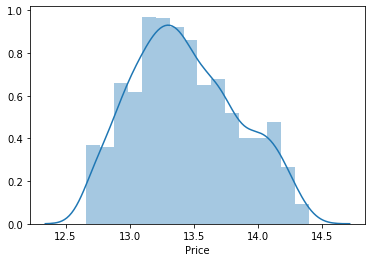

In [760]:
ax = sns.distplot(house_df['Price'])

In [761]:
col_remove = ["Title", "Place", "Post Timing", "Link"]
house_df.drop(col_remove, axis= 1, inplace =True)

In [762]:
house_df.head()

,Price,Bedroom,Area,isFurnished,House Type,Parking Type,Bathroom
1,13.437,2,734.400,unfurnished,condo,attached garage,2.000
5,13.056,1,530.000,unfurnished,apartment,attached garage,1.000
6,13.617,1,1300.000,unfurnished,townhouse,attached garage,1.000
7,13.452,More than 5,679.000,unfurnished,apartment,attached garage,1.000
8,14.220,2,186.000,unfurnished,condo,attached garage,2.000


In [763]:
house_df.shape

(1101, 7)

In [764]:
# house_df["reverseLog"] = Z =  np.exp(house_df["logPrice"])

In [766]:
house_df["Bathroom"].unique()

array([2.0, 1.0, 1.5, 3.0, 2.5, 'More than 3'], dtype=object)

In [769]:
final_df = pd.get_dummies(house_df, drop_first=True)

In [770]:
final_df.head(20)

,Price,Area,Bedroom_1,Bedroom_2,Bedroom_3,Bedroom_4,Bedroom_5,Bedroom_More than 5,isFurnished_unfurnished,House Type_condo,...,House Type_others,House Type_townhouse,Parking Type_detached garage,Parking Type_no parking,Parking Type_street parking,Bathroom_1.5,Bathroom_2.0,Bathroom_2.5,Bathroom_3.0,Bathroom_More than 3
1,13.437,734.400,0,1,0,0,0,0,1,1,...,0,0,0,0,0,0,1,0,0,0
5,13.056,530.000,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,13.617,1300.000,1,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
7,13.452,679.000,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
8,14.220,186.000,0,1,0,0,0,0,1,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48,13.227,651.000,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0
51,13.236,1435.000,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
53,13.196,950.000,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
54,12.731,855.000,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### Linear Regression

In [780]:
X = final_df.iloc[:, 1:]
y = final_df.iloc[:, 0]

In [782]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [783]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, X, y, cv=10)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

In [784]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression(normalize=True)
lin_reg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [785]:
print(lin_reg.intercept_)

13.077113742817422


In [786]:
coeff_df = pd.DataFrame(lin_reg.coef_, X.columns, columns=['Coefficient'])
coeff_df

,Coefficient
Area,0.000
Bedroom_1,-0.087
Bedroom_2,-0.055
Bedroom_3,0.017
Bedroom_4,0.118
...,...
Bathroom_1.5,0.026
Bathroom_2.0,0.281
Bathroom_2.5,0.412
Bathroom_3.0,0.385


In [787]:
pred = lin_reg.predict(X_test)

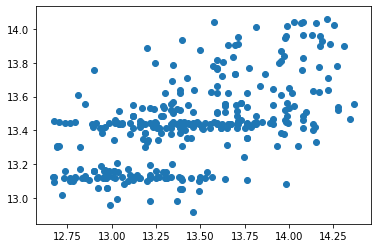

In [788]:
plt.scatter(y_test, pred)

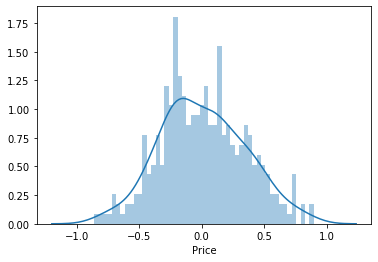

In [789]:
sns.distplot((y_test - pred), bins=50);

In [790]:


print_evaluate(y_test, lin_reg.predict(X_test))



MAE: 0.2766485982758395
MSE: 0.11540262378174064
RMSE: 0.3397096168520118
R2 Square 0.3338756162816847


In [791]:
results_df = pd.DataFrame(data=[["Linear Regression", *evaluate(y_test, pred) , cross_val(LinearRegression())]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,0.277,0.115,0.340,0.334,0.323


In [793]:
# open a file, where you ant to store the data
file = open('lin_reg_house_price.pkl', 'wb')

# dump information to that file
pickle.dump(lin_reg, file)

In [794]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))        

seaborn==0.9.0
scikit-learn==0.21.3
pandas==1.0.4
numpy==1.16.5
matplotlib==3.1.1
